In [1]:
import torch
import numpy as np
import seaborn as sns

import sys
sys.path.append('..')
import datafree

In [2]:
!nvidia-smi

Fri Mar 18 10:33:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:04:00.0 Off |                  N/A |
| 73%   63C    P2   313W / 350W |  11421MiB / 24268MiB |     71%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:05:00.0 Off |                  N/A |
| 86%   

In [3]:
distributed = False
gpu = 4
batch_size = 256
workers = 8
num_classes = 10
def prepare_model(model):
    if not torch.cuda.is_available():
        print('using CPU, this will be slow')
        return model
    elif distributed:
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if args.gpu is not None:
            torch.cuda.set_device(gpu)
            model.cuda(gpu)
            # When using a single GPU per process and per
            # DistributedDataParallel, we need to divide the batch size
            # ourselves based on the total number of GPUs we have
            batch_size = int(batch_size / ngpus_per_node)
            workers = int((workers + ngpus_per_node - 1) / ngpus_per_node)
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[gpu])
            return model
        else:
            model.cuda()
            model = torch.nn.parallel.DistributedDataParallel(model)
            return model
    elif gpu is not None:
        torch.cuda.set_device(gpu)
        model = model.cuda(gpu)
        return model
    else:
        # DataParallel will divide and allocate batch_size to all available GPUs
        model = torch.nn.DataParallel(model).cuda()
        return model

In [4]:
from torchvision.datasets import CIFAR10
import registry
student = registry.get_model('resnet18', num_classes=num_classes)
teacher = registry.get_model('resnet34', num_classes=num_classes, pretrained=True).eval()
normalizer = datafree.utils.Normalizer(**registry.NORMALIZE_DICT['cifar10'])
student = prepare_model(student)
teacher = prepare_model(teacher)
teacher.load_state_dict(torch.load('/data/lijingru/DataFree/checkpoints/scratch/cifar10_resnet34.pth', map_location='cpu')['state_dict'])
teacher.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [5]:
def get_losses(t_out, t_feat):
    p = F.softmax(t_out, dim=1).mean(0)
    ent = (p*p.log()).sum()
    loss_oh = F.cross_entropy( t_out, t_out.max(1)[1])
    loss_act = - t_feat.abs().mean()
    return {'neg_ent': ent.item(), 't_conf': loss_oh.item(), 'l_act': loss_act.item()}

In [9]:
import numpy as np
num_classes, ori_dataset, val_dataset = registry.get_dataset(name='cifar10', data_root='/data/lijingru/cifar10/')
random_idx = np.random.randint(0, len(val_dataset), (256,))

Files already downloaded and verified
Files already downloaded and verified


In [10]:
x_feats = []
outputs = []
labels = []
xs = []
real_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=workers, pin_memory=True)
for data in real_loader:
    x, y = data
    xs.append(x.cpu().numpy())
    x = x.to(gpu)
    output, x_feat = teacher(x, return_features=True)
    x_feats.append(x_feat.detach().cpu().numpy())
    outputs.append(output.detach().cpu().numpy())
    labels.append(y.detach().cpu().numpy())

(0.4914, 0.4822, 0.4465)
[0.01391149 0.01470116 0.01944823] [1.4865491 1.483806  1.6937859]
0 [0.20962143 0.45027354 0.79351974] [1.508555  1.4203671 1.6655258]
1 [-0.10251226 -0.13846582  0.00965419] [1.7754782 1.7891607 1.8742659]
2 [-0.00722225  0.06401531 -0.09086239] [1.2530116 1.231406  1.4907234]
3 [ 0.00983129 -0.13508265 -0.15172651] [1.5913854 1.5636282 1.6056801]
4 [-0.13040288 -0.11454726 -0.37751466] [1.1116626 1.0219193 1.0296729]
5 [ 0.08873951 -0.03846535 -0.10630681] [1.5450723 1.5040188 1.561377 ]
6 [-0.08143532 -0.20027477 -0.49995804] [1.2894008 1.2092412 1.2082083]
7 [ 0.06763753  0.00630896 -0.10439368] [1.4519054 1.5011125 1.6151615]
8 [0.01591104 0.2128494  0.5289252 ] [1.5108435 1.4446062 1.5525004]
9 [0.06894646 0.04040009 0.19314529] [1.7344235 1.8088093 1.945724 ]


/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

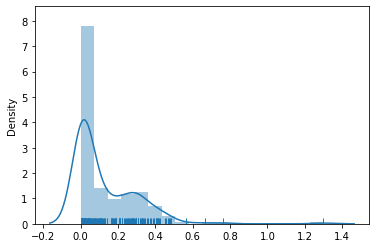

In [11]:
x_feats_all = np.vstack(x_feats)
outputs_all = np.vstack(outputs)
y_all = np.hstack(labels)
xs_all = np.concatenate(xs)
print(registry.NORMALIZE_DICT['cifar10']['mean'])
print(np.mean(xs_all, (0,2,3)), np.var(np.transpose(xs_all, (1,0,2,3)).reshape(xs_all.shape[1], -1), 1))
for i in range(num_classes):
    this_xs = xs_all[y_all == i]
    print(i, np.mean(this_xs, (0,2,3)), np.var(np.transpose(this_xs, (1,0,2,3)).reshape(this_xs.shape[1], -1), 1))

x_feats = x_feats_all[random_idx]
outputs = outputs_all[random_idx]
c_feat = x_feats[:, 15]
sns.distplot(c_feat, rug=True)

### Synthetic Performance at $L = 1$
With no distribution alignment at feature map level. Ablation study for further research, and it should be close to the result of DAFL.

In [12]:
G = datafree.models.generator.DCGAN_Generator_CIFAR10(nz=512, ngf=64, img_size=32, d=2, nc=3)
G = prepare_model(G)
ckpt_path = '/data/lijingru/DataFree/checkpoints/datafree-probkd/cifar10-resnet34-resnet18--probkd_L2_reinter.pth'
ckpt = torch.load(ckpt_path, map_location='cuda:{}'.format(gpu))
G.load_state_dict(ckpt['G_0'])
G.eval()

DCGAN_Generator_CIFAR10(
  (project): Sequential(
    (0): Flatten()
    (1): Linear(in_features=512, out_features=16384, bias=True)
  )
  (main): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
  )
  (trans_convs): ModuleList(
    (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
 

In [13]:
import torch.nn.functional as F
z = torch.randn(256, 512).to(gpu)
xs = G(z, l=0)
x_out0, x_feat_inter = teacher(normalizer(xs), return_features=True)
# l1_div = F.l1_loss(x_out.detach().cpu(), torch.FloatTensor(outputs), reduction='none').sum(1).mean(0)
kl_div1 = F.kl_div(torch.log_softmax(x_out0.detach().cpu(), 1), torch.softmax(torch.FloatTensor(outputs), 1), reduction='batchmean')
print('KL(T(x_G0) || T(x_real)) = {:.4f}'.format(kl_div1))
# print('L1(T(x_G0) || T(x_real)) = {:.4f}'.format(l1_div))


KL(T(x_G0) || T(x_real)) = 6.3074


In [14]:
loss = get_losses(x_out0, x_feat_inter)

print(loss)
loss = get_losses(torch.FloatTensor(outputs), torch.FloatTensor(x_feats))
print(loss)

{'neg_ent': -2.288909912109375, 't_conf': 0.2808639705181122, 'l_act': -0.1889744997024536}
{'neg_ent': -2.2943294048309326, 't_conf': 0.02624056674540043, 'l_act': -0.18696367740631104}


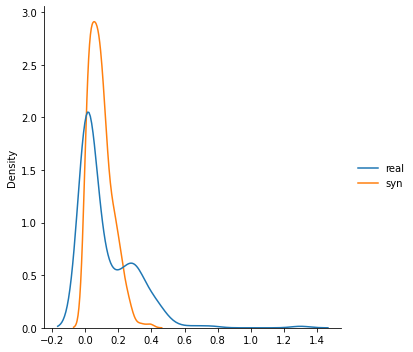

In [15]:
x_feat_inter = x_feat_inter.detach().cpu().numpy()
import pandas as pd
c = 15
a = pd.DataFrame(data={'real': x_feats[:, c], 'syn':x_feat_inter[:, c]})
sns.displot(a, kind='kde')

<AxesSubplot:xlabel='real', ylabel='count'>

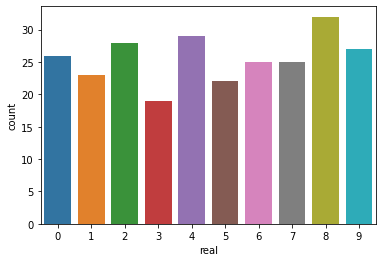

In [16]:
b = pd.DataFrame(data={'real': np.argmax(outputs, 1), 'syn': np.argmax(x_out0.detach().cpu().numpy(), 1)})
sns.countplot(x='real', data=b)

<AxesSubplot:xlabel='syn', ylabel='count'>

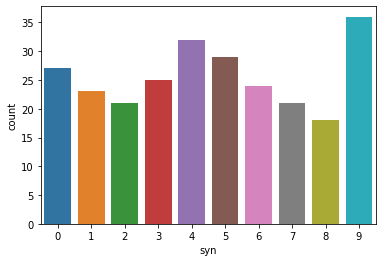

In [17]:
sns.countplot(x='syn', data=b)

In [18]:
def print_mean_var(xs, ys):
    print(xs.shape, ys.shape)
    mu, sigma2 = np.mean(xs, (0,2,3)), np.var(xs, (0,2,3))
    print(mu, sigma2)
    for i in range(num_classes):
        this_x = xs[ys == i]
        mu_i, sigma2_i = np.mean(this_x, (0,2,3)), np.var(this_x, (0,2,3))
        print(i, mu_i, sigma2_i)

In [19]:
print_mean_var(normalizer(xs).detach().cpu().numpy(), np.argmax(x_out0.detach().cpu().numpy(), 1))

(256, 3, 32, 32) (256,)
[-0.46463606  0.55292684  0.5418226 ] [2.9193802 2.54968   2.5833285]
0 [-0.61799806  0.9163718   0.78260124] [2.8358352 2.2632987 2.555391 ]
1 [-0.6108469   0.26927507  0.39852902] [2.7795851 2.6046107 2.5747154]
2 [-0.5504487   0.5106478   0.34146303] [2.9634542 2.6307034 2.6239908]
3 [-0.28776836  0.6541828   0.6729447 ] [3.039659  2.4712656 2.5054247]
4 [-0.36303872  0.2988691   0.56598306] [2.7032883 2.376074  2.2094688]
5 [-0.46529534  0.25127742  0.1966701 ] [3.082611  2.8184211 2.676884 ]
6 [-0.624849    0.94555336  0.3043093 ] [3.245097  2.589493  3.1571624]
7 [-0.06349307  0.43688655  0.5731602 ] [3.0022652 2.5318055 2.4096217]
8 [-0.3780957   0.49483988  0.804945  ] [2.6134005 2.250469  2.1184149]
9 [-0.58920795  0.71971774  0.7436707 ] [2.7134624 2.37845   2.5463648]


### Feature map distribution and Categorial Distribution
Visualization of distribution with the alignemnt at feature map level.

In [20]:
G = datafree.models.generator.DCGAN_Generator_CIFAR10(nz=512, ngf=64, img_size=32, d=2, nc=3, cond=True)
G = prepare_model(G)
ckpt_path = '/data/lijingru/DataFree/checkpoints/datafree-probkd/cifar10-resnet34-resnet18--probkd_L2_line33_2.pth'
ckpt = torch.load(ckpt_path, map_location='cuda:{}'.format(gpu))
G.load_state_dict(ckpt['G_0'])
G.eval()

DCGAN_Generator_CIFAR10(
  (emb): Embedding(10, 50)
  (project): Sequential(
    (0): Flatten()
    (1): Linear(in_features=562, out_features=16384, bias=True)
  )
  (main): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
  )
  (trans_convs): ModuleList(
    (0): Conv2d(128, 128, kernel_si

In [21]:
import torch.nn.functional as F
l = 0

if l == 0:
    func = normalizer
else:
    t_layer = getattr(teacher, 'layer{}'.format(l))
#     func = lambda x: F.relu(t_layer[-1].bn2(t_layer[-1].conv2(F.relu(t_layer[-1].bn1(x)))))
    func = lambda x: F.relu(x)
# z = torch.randn(256, 512).to(gpu)
layers = [teacher.bn1, teacher.layer1[-1].bn2, teacher.layer2[-1].bn2, teacher.layer3[-1].bn2]
stats = [(f.running_mean.data, f.running_var.data) for f in layers]
y_t = torch.randint(0, num_classes, (z.size(0), ), device='cuda:{}'.format(gpu))
xs = G(z, l=l, y=y_t)
b,c,h,w = xs.size()
if l > 0:
    mu_l, var_l = stats[l]
#     dist = torch.distributions.Normal(mu_l, var_l)
#     real_sample = dist.sample((b*h*w,))
#     real_sample = real_sample.view([b, h, w, c]).permute(0,3,1,2)
    real_sample = mu_l.unsqueeze(0).unsqueeze(2).unsqueeze(3) + torch.sqrt(var_l).unsqueeze(0).unsqueeze(2).unsqueeze(3) * torch.randn_like(xs.detach())
#     print(stats[3])

# G samples at l-th layer
x_out, x_feat_inter_relu = teacher(func(xs), return_features=True, l=l)
x_feat_inter_relu = x_feat_inter_relu.detach().cpu().numpy()
# Real samples at l-th layer
if l > 0:
    x_out_r, x_feat_inter_relu_r = teacher(func(real_sample), return_features=True, l=l)
    x_feat_inter_relu_r = x_feat_inter_relu_r.detach().cpu().numpy()

In [22]:
# l1_div = F.l1_loss(x_out.detach().cpu(), torch.FloatTensor(outputs), reduction='none').sum(1).mean(0)
kl_div1 = F.kl_div(torch.log_softmax(x_out.detach().cpu(), 1), torch.softmax(torch.FloatTensor(outputs), 1), reduction='batchmean')
print('KL(T(x_G0) || T(x_real)) = {:.4f}'.format(kl_div1))
print_mean_var(normalizer(xs).detach().cpu().numpy(), y_t.cpu().numpy())
# print('L1(T(x_G0) || T(x_real)) = {:.4f}'.format(l1_div))

KL(T(x_G0) || T(x_real)) = 15.1380
(256, 3, 32, 32) (256,)
[-0.07603677  0.59253514  1.3678206 ] [1.3417808 1.7861143 1.3383904]
0 [0.40146974 0.75124997 2.0562234 ] [1.1252387  1.7291673  0.87634414]
1 [ 0.003657   -0.20067398  1.4917222 ] [1.4225738 2.3553584 1.4379989]
2 [-0.2722337  0.612925   1.129899 ] [1.1616534 1.4815243 1.247998 ]
3 [-0.13150743  0.79795444  1.313211  ] [1.3035566 1.877096  1.4822968]
4 [-0.39756376  1.179716    1.5997293 ] [1.1069435  0.82019347 0.83010906]
5 [0.3306638  0.17828752 1.1974624 ] [1.5254538 2.6471348 1.9506737]
6 [-0.2390618   0.21198413  1.0585406 ] [1.191212  2.1416469 1.8148228]
7 [-0.13623375  0.78961176  1.0743093 ] [1.7695115 1.3351818 1.311547 ]
8 [-0.13086219  0.7149704   1.3000925 ] [1.0578184 1.3078617 1.0669775]
9 [-0.17688774  0.8069058   1.3235768 ] [1.3434573 1.0270798 0.8999489]


In [21]:
print(mu_l, var_l)
nch = xs.size(1)
# print(torch.mean(real_sample, (0,2,3)), real_sample.permute(1,0,2,3).contiguous().view([nch, -1]).var(1, unbiased=False))
print(torch.mean(xs, (0,2,3)), xs.permute(1,0,2,3).contiguous().view([nch, -1]).var(1, unbiased=False))

NameError: name 'mu_l' is not defined

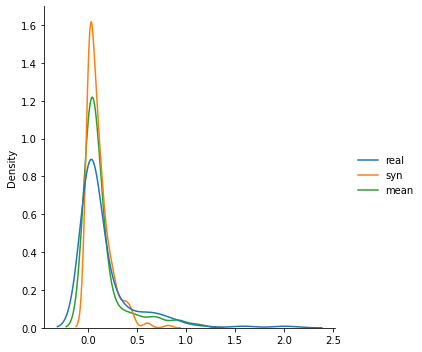

In [23]:
c = 12
# print(x_out[:, c])
# print(x_out_r[:, c])
# a = pd.DataFrame(data={'real': x_feats[:, c], 'syn':x_feat_inter[:, c], 'mean':x_feat_inter_relu[:, c]})
# print(x_feats.shape, x_feat_inter.shape, x_feat_inter_relu.shape, x_feat_inter_relu_r.shape)
# print(x_feat_inter_relu_r[:, c])
all_dict_feat = {'real': x_feats[:, c], 'syn':x_feat_inter[:, c], 'mean':x_feat_inter_relu[:, c]}
# if l > 0:
#     all_dict['real_sample'] = x_feat_inter_relu_r[:, c]
a = pd.DataFrame(data=all_dict_feat)
sns.displot(a, kind='kde')

<AxesSubplot:xlabel='real', ylabel='count'>

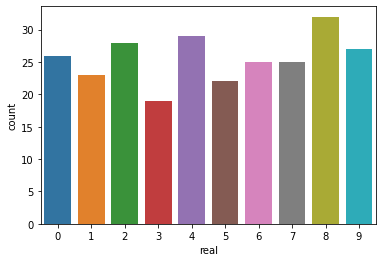

In [24]:
# print(outputs, x_out, x_out_r)
all_dict = {'real': np.argmax(outputs, 1), 'mean':x_out.argmax(1).detach().cpu().numpy()}
if l > 0:
    all_dict['real_sample'] = x_out_r.argmax(1).detach().cpu().numpy()
b = pd.DataFrame(data=all_dict)
sns.countplot(x='real', data=b)

<AxesSubplot:xlabel='mean', ylabel='count'>

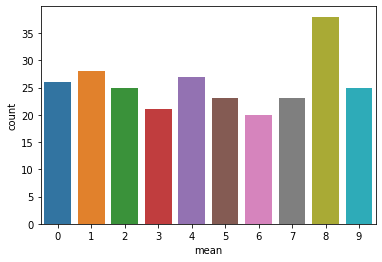

In [25]:
sns.countplot(x='mean', data=b)

In [26]:
loss_syn = get_losses(x_out.cpu(), torch.FloatTensor(x_feat_inter_relu))
print(loss_syn)
loss = get_losses(torch.FloatTensor(outputs), torch.FloatTensor(x_feats))
print(loss)

{'neg_ent': -2.286372184753418, 't_conf': 2.2865086066303775e-05, 'l_act': -0.21209749579429626}
{'neg_ent': -2.2943294048309326, 't_conf': 0.02624056674540043, 'l_act': -0.18696367740631104}


### t-SNE of samples by different $L$s
Visualize data distribution at different levels of feature map.

In [27]:
from sklearn.manifold import TSNE
from matplotlib import pyplot
tsne = TSNE(n_components=2, n_iter=5000, init='pca', verbose=1)

/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.000s...
[t-SNE] Computed neighbors for 256 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 3.289136


/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.186943
[t-SNE] KL divergence after 1950 iterations: 0.224452


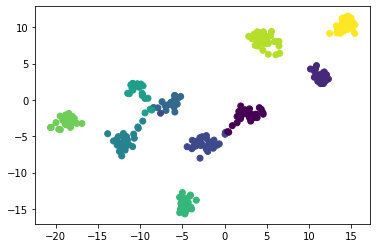

In [28]:
X_real = tsne.fit_transform(x_feats)
# print(y_all)
y_real = np.argmax(outputs, 1)
pyplot.scatter(X_real[:, 0], X_real[:, 1], c=y_real)


/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.000s...
[t-SNE] Computed neighbors for 256 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 1.704911


/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.977577
[t-SNE] KL divergence after 1250 iterations: 0.819059


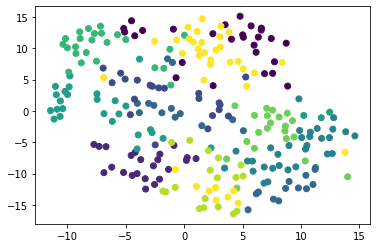

In [29]:
X_real = tsne.fit_transform(x_feat_inter)
# print(y_all)
pyplot.scatter(X_real[:, 0], X_real[:, 1], c=x_out0.argmax(1).detach().cpu().numpy())

/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.000s...
[t-SNE] Computed neighbors for 256 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 2.763563


/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.109573
[t-SNE] KL divergence after 1650 iterations: 0.043626


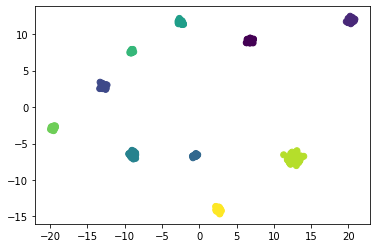

In [30]:
X_real_syn = tsne.fit_transform(x_feat_inter_relu)
# print(y_all)
y_syn = x_out.argmax(1).detach().cpu().numpy()
pyplot.scatter(X_real_syn[:, 0], X_real_syn[:, 1], c=y_syn)

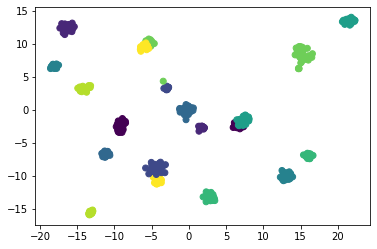

In [62]:
pyplot.scatter(np.hstack([X_real_syn[:, 0], X_real[:, 0]]), np.hstack([X_real_syn[:, 1], X_real[:, 1]]), c=np.hstack([y_syn, y_real]))

In [25]:
_, (real_x, real_y) = enumerate(real_loader).__next__()
# print(real_x.shape, real_y.shape)
layer = getattr(teacher, 'layer{}'.format(l))
l_func = lambda x: teacher.layer2[:-1](F.relu(teacher.bn1(teacher.conv1(x))))
new_func = lambda x: teacher.layer2[-1].conv1(x)
new_func2 = lambda x, y: F.relu(layer[-1].bn2(layer[-1].conv2(F.relu(layer[-1].bn1(x))))+layer[-1].shortcut(y))
real_real_sample1 = l_func(real_x.to(gpu))
real_real_sample = new_func(real_real_sample1)
b,c,h,w = real_sample.size()
print(real_real_sample1.permute(1,0,2,3).contiguous().view([nch, -1]))
print(real_sample.permute(1,0,2,3).contiguous().view([nch, -1]))
out_x, out_feat = teacher(new_func2(real_real_sample, real_real_sample1), l=l, return_features=True)
all_dict['concat_real'] = out_x.argmax(1).detach().cpu().numpy()
# print(real_sample.shape)
b = pd.DataFrame(data=all_dict)
sns.countplot(x='concat_real', data=b)
# print(torch.mean(real_real_sample, (0,2,3)), real_real_sample.permute(1,0,2,3).contiguous().view([nch, -1]).var(1))
# print(torch.mean(func(real_sample), (0,2,3)), func(real_sample).permute(1,0,2,3).contiguous().view([nch, -1]).var(1, unbiased=False))
# print(mu_l, var_l)
# print(torch.mean(real_sample, (0,2,3)), real_sample.permute(1,0,2,3).contiguous().view([nch, -1]).var(1))
# print(real_sample)
# print('************')
# print(real_real_sample)
# print(torch.mean(real_sample, (2, 3)).var(0))
# print(torch.mean(real_real_sample, (2, 3)).var(0))
# dist = torch.distributions.Normal(mu_l, var_l)
# this_real_sample = dist.sample((b*h*w,))
# this_real_sample = this_real_sample.view([b, h, w, c]).permute(0,3,1,2)

# print(torch.mean(this_real_sample, (0,2,3)), this_real_sample.permute(1,0,2,3).contiguous().view([nch, -1]).var(1))

# print(mu_l - torch.mean(real_sample, (2, 3)).min(0)[0])
# print(mu_l - torch.mean(real_real_sample, (2,3)).min(0)[0])

tensor([[0.5922, 0.7885, 0.4750,  ..., 0.3057, 0.3211, 0.2452],
        [0.0000, 0.0000, 0.0000,  ..., 0.4029, 0.3721, 0.0774],
        [0.0000, 0.0000, 0.1842,  ..., 0.7598, 1.1055, 1.0439],
        ...,
        [1.2949, 1.7612, 1.5024,  ..., 0.3091, 0.2729, 0.0411],
        [0.1986, 0.1247, 0.0835,  ..., 0.1689, 0.1585, 0.0466],
        [0.0560, 0.1115, 0.1753,  ..., 0.2808, 0.3218, 0.4398]],
       device='cuda:2', grad_fn=<ViewBackward>)
tensor([[-0.6498, -0.3631, -0.0377,  ..., -0.6857, -0.9038, -0.5048],
        [-0.1964,  0.7827, -1.1429,  ..., -0.3629,  0.8135,  0.6026],
        [ 0.7798, -0.1770,  0.1008,  ...,  0.4154,  0.1110,  0.5587],
        ...,
        [ 1.6031,  0.7584, -0.3596,  ...,  0.7885,  1.6501, -1.0623],
        [-1.1224, -0.5100, -0.9289,  ...,  0.3350, -0.4403, -0.7031],
        [-0.2611, -0.4282,  1.4104,  ...,  0.2826,  0.9727,  0.4883]],
       device='cuda:2')


RuntimeError: running_mean should contain 128 elements not 64

In [26]:
# import pandas as pd
l = 1
layer = getattr(teacher, 'layer{}'.format(l))
G = datafree.models.generator.DCGAN_Generator_CIFAR10_more(nz=512, ngf=64, img_size=32, d=2, nc=3)
G = prepare_model(G)
ckpt_path = '/data/lijingru/DataFree/checkpoints/datafree-probkd/cifar10-resnet34-resnet18--probkd_L2_bn1_shortcut.pth'
ckpt = torch.load(ckpt_path, map_location='cuda:{}'.format(gpu))
G.load_state_dict(ckpt['G_{}'.format(l)])
G.eval()

z = torch.randn(256, 512).to(gpu)
xs, real_x = G(z, l=l)
x_out, x_feat_inters = teacher(new_func2(xs, real_x), return_features=True, l=l)
x_feat_inters = x_feat_inters.detach().cpu().numpy()
print(x_feat_inters.shape)

c = 15
a = pd.DataFrame(data={'real': x_feats[:, c], 'mean':x_feat_inter_relu[:, c]})
sns.displot(a, kind='kde')

FileNotFoundError: [Errno 2] No such file or directory: '/data/lijingru/DataFree/checkpoints/datafree-probkd/cifar10-resnet34-resnet18--probkd_L2_bn1_shortcut.pth'

In [39]:
print(get_losses(x_out.cpu(), torch.FloatTensor(x_feat_inters)))
print(torch.mean(new_func(real_x), (2,3)), torch.mean(xs, (2,3)))

{'neg_ent': -2.2820231914520264, 't_conf': 0.3896195888519287, 'l_act': -0.17438821494579315}
tensor([[-0.0771,  0.2484, -0.2477,  ...,  0.1499,  0.0925,  0.1499],
        [-0.0529,  0.1834, -0.1757,  ...,  0.1203,  0.0693,  0.0949],
        [-0.0820,  0.2229, -0.2485,  ...,  0.1559,  0.0712,  0.1564],
        ...,
        [-0.0652,  0.1867, -0.1700,  ...,  0.0839,  0.0560,  0.0732],
        [-0.1253,  0.1327, -0.2509,  ...,  0.0498,  0.0075,  0.1808],
        [-0.0603,  0.1768, -0.0876,  ...,  0.0055,  0.0496, -0.0445]],
       device='cuda:2', grad_fn=<MeanBackward1>) tensor([[-0.0467,  0.2571, -0.2314,  ...,  0.1285,  0.0977,  0.1550],
        [-0.0355,  0.1898, -0.1674,  ...,  0.0916,  0.0705,  0.1047],
        [-0.0522,  0.2334, -0.2371,  ...,  0.1278,  0.0816,  0.1704],
        ...,
        [-0.0420,  0.1958, -0.1646,  ...,  0.0676,  0.0654,  0.0810],
        [-0.0993,  0.1369, -0.2444,  ...,  0.0258,  0.0139,  0.1925],
        [-0.0411,  0.1826, -0.0950,  ..., -0.0083,  0.0667, 

<AxesSubplot:xlabel='real', ylabel='count'>

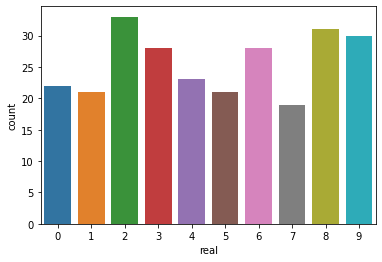

In [36]:
all_dict = {'real': np.argmax(outputs, 1), 'mean':x_out.argmax(1).detach().cpu().numpy()}
b = pd.DataFrame(data=all_dict)
sns.countplot(x='real', data=b)

<AxesSubplot:xlabel='mean', ylabel='count'>

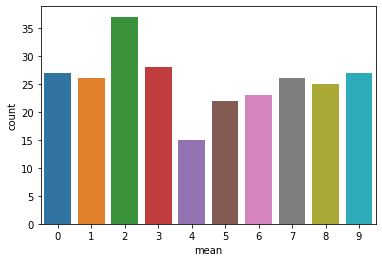

In [37]:
sns.countplot(x='mean', data=b)